In [1]:
from model import SpatialTemporalTransformer
from data import SoilMoisture, GP, KaustCompetition, AQ36, AQ
from utils import SpatialTemporalTransformerDataset
import yaml
from torch.utils.data import DataLoader
import numpy as np

In [2]:

# config_file = 'experiment/st_transformer/air_quality_st_basis.yaml'
config_file = 'experiment/st_transformer/kaust_competition_st_basis.yaml'
# config_file = 'experiment/st_transformer/gp_st_basis.yaml'
with open(config_file, 'r') as fp:
    args = yaml.load(fp, Loader=yaml.FullLoader)


In [3]:
class Args:
    def __init__(self, args):
        res = {}
        for key, value in args.items():
            setattr(self, key, value)
args = Args(args)

In [4]:
best_model_path = f'checkpoints/{args.dataset}/{args.model}/best-checkpoint-v50.ckpt'
best_model_path

'checkpoints/KaustCompetition/SpatialTemporalTransformer/best-checkpoint-v50.ckpt'

In [5]:
model = SpatialTemporalTransformer.load_from_checkpoint(best_model_path, y_dim=args.y_dim, x_dim=args.x_dim, hidden_dims=args.hidden_dims, output_dim=args.output_dim, ff_dim=args.ff_dim, n_heads=args.n_heads, n_layers=args.n_layers, dropout=args.dropout, lr=args.lr, weight_decay=args.weight_decay, whiten_prob=args.whiten_prob)


In [6]:
if args.dataset == 'GP':
    st_dataset = GP(args.num_nodes, args.seq_len)
elif args.dataset == 'KaustCompetition':
    st_dataset = KaustCompetition(args.dataset_index)
elif args.dataset == 'SoilMoisture':
    st_dataset = SoilMoisture()
elif args.dataset == 'AirQuality':
    st_dataset = AQ36()
elif args.dataset == 'AQ':
    st_dataset = AQ()
elif args.dataset == 'GP':
    st_dataset = GP()
else:
    raise ValueError('Invalid dataset name')
y, x, mask, eval_mask, space_coords, time_coords = st_dataset.y, st_dataset.x, st_dataset.mask, st_dataset.eval_mask, st_dataset.space_coords, st_dataset.time_coords
dataset = SpatialTemporalTransformerDataset(y, x, mask, eval_mask, space_coords, time_coords, args.correlation_threshold, args.space_partitions_num, args.window_size, args.stride, args.val_ratio, args.additional_st_covariates, args.normalization_axis, args.training_strategy)

Computing METIS partitioning...
Done!


In [7]:
spatial_partitions = dataset.spatial_partitions
time_partitions = dataset.time_partitions

In [8]:
time_partitions

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]

In [9]:
print(len(spatial_partitions), len(time_partitions))

50 10


In [10]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [11]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
dataloader_iterator = iter(dataloader)

model.eval()
device = 'mps'
model.to(device)

y_pred = np.zeros_like(dataset.y)


count = 0

for j in range(len(time_partitions)):
    for i in range(len(spatial_partitions)):
        count += 1
        # if count % 100 == 0:
        #     print(count)
        batch = next(dataloader_iterator)
        y = batch['y'].to(device)
        mask = batch['mask'].to(device)
        eval_mask = batch['eval_mask'].to(device)

        if eval_mask.sum() == 0:
            continue



        observed_mask = mask - eval_mask
        y_observed = y * observed_mask
        y_target = y * eval_mask

        x = batch['x'].to(device)
    


        y_hat = model(y_observed, observed_mask, x)
        y_hat = y_hat.squeeze(-1)
       
       
    

        mean = batch['mean'].to(device)
        std = batch['std'].to(device)
        y_hat = y_hat * std + mean

        y_hat = y_hat * eval_mask

         

        y_hat = y_hat.squeeze(0).detach().cpu().numpy()

        # for k in range(len(spatial_partitions[i])):
        #     for l in range(len(time_partitions[j])):
        #         y_pred[spatial_partitions[i][k], time_partitions[j][l]] = y_hat[k, l]
        spatial_indices = np.array(spatial_partitions[i])
        time_indices = np.array(time_partitions[j])
        y_pred[spatial_indices[:, None], time_indices] = y_hat[:len(spatial_indices), :len(time_indices)]


     
# print(y_pred)    
       




In [12]:
eval_mask = dataset.eval_mask
y = dataset.y
y_true = y * eval_mask

In [13]:
# index of true
np.where(eval_mask[0, :] == 1)[0]

array([42, 51, 71, 81, 88, 94])

In [14]:
np.mean(np.abs(y_true[eval_mask == 1] - y_pred[eval_mask == 1]))

0.61655235

In [15]:
from utils import pairwise_correlation
correlation_matrix_true = pairwise_correlation(y_true, eval_mask)
correlation_matrix_pred = pairwise_correlation(y_pred, eval_mask)





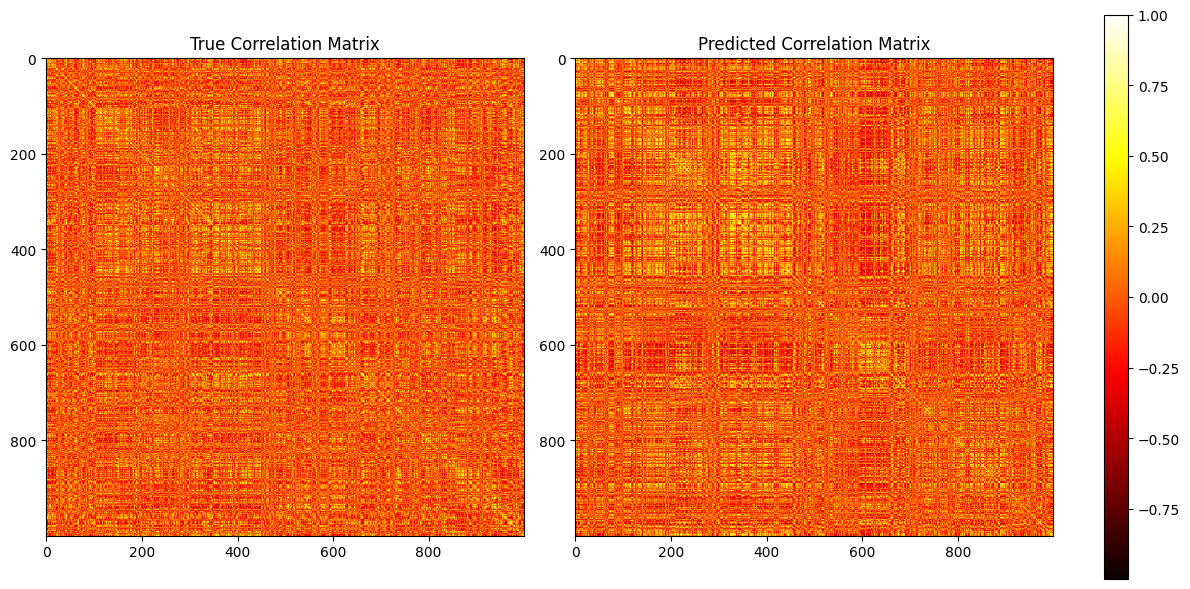

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

# Assuming correlation_matrix_true and correlation_matrix_pred are your matrices
# Get the minimum and maximum values across both matrices
vmin = min(np.min(correlation_matrix_true), np.min(correlation_matrix_pred))
vmax = max(np.max(correlation_matrix_true), np.max(correlation_matrix_pred))

# Create a gridspec for better control of the layout
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05])

# Plot the true correlation matrix
ax0 = plt.subplot(gs[0])
cax1 = ax0.imshow(correlation_matrix_true, cmap='hot', vmin=vmin, vmax=vmax)
ax0.set_title('True Correlation Matrix')

# Plot the predicted correlation matrix
ax1 = plt.subplot(gs[1])
cax2 = ax1.imshow(correlation_matrix_pred, cmap='hot', vmin=vmin, vmax=vmax)
ax1.set_title('Predicted Correlation Matrix')

# Add a colorbar that doesn't overlap with the figures
cbar_ax = plt.subplot(gs[2])
plt.colorbar(cax1, cax=cbar_ax)

# Adjust the layout
plt.tight_layout()
plt.show()

